In [708]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

In [1296]:
def __p(phi):
    return phi*phi*phi*(10-15*phi+6*phi*phi)

def __g(phi):
    return (phi*phi*(1-phi)*(1-phi))

def __gprime(phi):
    return (4*phi*phi*phi - 6*phi*phi +2*phi)

_p = np.vectorize(__p)
_g = np.vectorize(__g) 
_gprime = np.vectorize(__gprime)

def grad(phi, dx, i):
    phim = np.roll(phi, -1, 0)
    phip = np.roll(phi, 1, 0)
    return (phip-phim)/(2*dx)

def grad_abs(phi, p, dx, length):
    rv = np.array(phi)
    pm = np.roll(p, -1, 0)
    pp = np.roll(p, 1, 0)
    phim = np.roll(phi, -1, 0)
    phip = np.roll(phi, 1, 0)
    for i in range(length):
        if(phi[i] < phip[i] and phi[i] < phim[i]):
            rv[i] = p[i]*(phip[i]+phim[i]-2*phi[i])/(2*dx)
        elif(phi[i] < phip[i] and phi[i] < phim[i]):
            rv[i] = p[i]*(phip[i]+phim[i]-2*phi[i])/(2*dx)
        else:
            rv[i] = (pp[i]-pm[i])*(phip[i]-phim[i])/(4*dx*dx)
    return rv

def grad2(phi, dx):
    phim = np.roll(phi, -1, 0)
    phip = np.roll(phi, 1, 0)
    return (phip+phim-2*phi)/(dx*dx)

def renormalize(q1, q2, q3, q4):
    q = np.sqrt(q1*q1+q2*q2+q3*q3+q4*q4)
    return q1/q, q2/q, q3/q, q4/q

In [1164]:
#material parameters
u = 100. #1 = cm, 100 = m
T_mA = 1728. #melting point of nickel
T_mB = 1358. #melting point of copper
L_A = 2350.*u*u*u #latent heat of nickel, J/m^3
L_B = 1728.*u*u*u #latent heat of copper, J/m^3
s_A = 0.000037*u*u #surface energy of nickel, J/m^2
s_B = 0.000029*u*u #surface energy of copper, J/m^2
D_L = 1e-5/(u*u) #diffusion in liquid, m^2/s
D_S = 1e-9/(u*u) #diffusion in solid, m^2/s
B_A = 0.33/u #linear kinetic coefficient of nickel, m/K/s
B_B = 0.39/u #linear kinetic coefficient of copper, m/K/s
v_m = 7.42/(u*u*u) #molar volume, m^3/mol
R = 8.314 #gas constant, J/mol*K
y_e = 0.06 #anisotropy

In [1313]:
np.set_printoptions(threshold=np.inf)
T = 1574.
res = 41
dx = 4.6e-6/u #spacial division, cm
dx = 1.31e-6/u
dt = dx*dx/5./D_L
dt = 1.31e-9
print(dt)
d = dx/0.94 #interfacial thickness
ebar = np.sqrt(6*np.sqrt(2)*s_A*d/T_mA) #baseline energy

W_A = 3*s_A/(np.sqrt(2)*T_mA*d)
W_B = 3*s_B/(np.sqrt(2)*T_mB*d)
M_A = T_mA*T_mA*B_A/(6*np.sqrt(2)*L_A*d)
M_B = T_mB*T_mB*B_B/(6*np.sqrt(2)*L_B*d)
ebar = np.sqrt(6*np.sqrt(2)*s_A*d/T_mA)
eqbar = ebar*0.1
print(M_A)
print(ebar)

c = np.zeros(res)
phi = np.zeros(res)
q1 = np.zeros(res)
q2 = np.zeros(res)
q3 = np.zeros(res)
q4 = np.zeros(res)
c += 0.40831
#c += 0.001*np.random.rand(res, res)
phi[0] = 1
phi[res-1] = 1
for i in range(res):
    q1[i] = (0.3*i)/(res-1)+0.5
    q2[i] = (0.3*(res-i-1))/(res-1)+0.5
    
print(q1)
print(q2)

reference = np.zeros(res)
for i in range(res):
    reference[i] = i

1.31e-09
35.4587860825
5.03192127727e-06
[ 0.5     0.5075  0.515   0.5225  0.53    0.5375  0.545   0.5525  0.56
  0.5675  0.575   0.5825  0.59    0.5975  0.605   0.6125  0.62    0.6275
  0.635   0.6425  0.65    0.6575  0.665   0.6725  0.68    0.6875  0.695
  0.7025  0.71    0.7175  0.725   0.7325  0.74    0.7475  0.755   0.7625
  0.77    0.7775  0.785   0.7925  0.8   ]
[ 0.8     0.7925  0.785   0.7775  0.77    0.7625  0.755   0.7475  0.74
  0.7325  0.725   0.7175  0.71    0.7025  0.695   0.6875  0.68    0.6725
  0.665   0.6575  0.65    0.6425  0.635   0.6275  0.62    0.6125  0.605
  0.5975  0.59    0.5825  0.575   0.5675  0.56    0.5525  0.545   0.5375
  0.53    0.5225  0.515   0.5075  0.5   ]


In [1326]:
#T = 1574
for i in range(2000):
    #print(i)
    g = _g(phi)
    p = _p(phi)
    gprime = _gprime(phi)
    H_A = W_A*gprime - 30*L_A*(1/T-1/T_mA)*g
    H_B = W_B*gprime - 30*L_B*(1/T-1/T_mB)*g
    phixx = grad2(phi, dx)
    lphi = phixx
    phix = grad(phi, dx, i)
    gq1 = grad(q1, dx, i)
    gq2 = grad(q2, dx, i)
    gq3 = grad(q3, dx, i)
    gq4 = grad(q4, dx, i)
    #print(gq1)
    smallest = 1e8*u*u
    gqs = gq1*gq1+gq2*gq2+gq3*gq3+gq4*gq4
    #print(gqs)
    for i in range(res):
        if(gqs[i] < smallest):
            gqs[i] = smallest
    rgqs = np.sqrt(gqs)
    lq1 = grad2(q1, dx)
    lq2 = grad2(q2, dx)
    lq3 = grad2(q3, dx)
    lq4 = grad2(q4, dx)
    gqs2 = gq1*lq1+gq2*lq2+gq3*lq3+gq4*lq4
    
    H = 5e-12*u*u # surface energy term for quaternions
    
    #change in c
    D_C = D_L+p*(D_S-D_L)
    temp = D_C*v_m*c*(1-c)*(H_B-H_A)/R
    deltac = D_C*(grad2(c, dx))+(grad(D_C, dx, i)*grad(c, dx, i))+temp*(lphi)+(grad(temp, dx, i)*phix)
    #print(deltac)
    #print(temp)
    
    #change in phi
    M_phi = 1.*((1-c)*M_A + c*M_B)
    deltaphi = M_phi*(ebar*ebar*lphi-(1-c)*H_A-c*H_B-60*H*T*g*rgqs)
    #randArray = 2*np.random.rand(res)-1
    #alpha = 0.3
    #deltaphi += M_phi*alpha*randArray*(16*g)*((1-c)*H_A+c*H_B)
    
    #changes in q
    M_q = 20.*M_phi*(1-p)
    gp2r = grad(p, dx, i)/rgqs
    p2r3 = p/(rgqs*gqs)
    
    #qs = q1*q1+q2*q2+q3*q3+q4*q4
    gaq1 = grad_abs(q1, p, dx, res)
    gaq2 = grad_abs(q2, p, dx, res)
    gaq3 = grad_abs(q3, p, dx, res)
    gaq4 = grad_abs(q4, p, dx, res)
    t1 = eqbar*eqbar*lq1+H*T*(gaq1/rgqs+p2r3*(lq1*gqs - gq1*gqs2))
    t2 = eqbar*eqbar*lq2+H*T*(gaq2/rgqs+p2r3*(lq2*gqs - gq2*gqs2))
    t3 = eqbar*eqbar*lq3+H*T*(gaq3/rgqs+p2r3*(lq3*gqs - gq3*gqs2))
    t4 = eqbar*eqbar*lq4+H*T*(gaq4/rgqs+p2r3*(lq4*gqs - gq4*gqs2))
    second = (q1*t1+q2*t2+q3*t3+q4*t4)#/qs
    deltaq1 = M_q*(t1-q1*second)
    deltaq2 = M_q*(t2-q2*second)
    deltaq3 = M_q*(t3-q3*second)
    deltaq4 = M_q*(t4-q4*second)
    #print(deltaq1)
    
    #apply changes
    deltaphi[0] = 0
    deltac[0] = 0
    deltaq1[0] = 0
    deltaq2[0] = 0
    deltaq3[0] = 0
    deltaq4[0] = 0
    deltaphi[res-1] = 0
    deltac[res-1] = 0
    deltaq1[res-1] = 0
    deltaq2[res-1] = 0
    deltaq3[res-1] = 0
    deltaq4[res-1] = 0
    #print(c)
    #print(phi)
    #print(q1)
    #print(q2)
    #print(q3)
    #print(q4)
    #print(gqs)
    #print("gp2r:", gp2r)
    #print("Second: ", second)
    #print("t4:", t4)
    
    ctemp = c.copy()
    c += deltac*dt
    phi += deltaphi*dt
    q1 += deltaq1*dt
    q2 += deltaq2*dt
    q3 += deltaq3*dt
    q4 += deltaq4*dt
    if(i%1 == 0):
        q1, q2, q3, q4 = renormalize(q1, q2, q3, q4)

#print(c)
#print(phi)
#print(q1)
#print(q2)
#print(q3)
#print(q4)    
print("Done")

Done


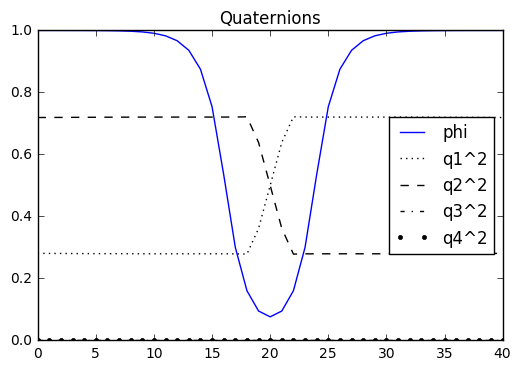

In [1327]:
plt.rcParams['figure.figsize'] = 6, 4
plt.title('Quaternions')
plt.plot(reference,phi, 'b')
plt.plot(reference,q1*q1,'k:')
plt.plot(reference,q2*q2,'k--')
plt.plot(reference,q3*q3,'k-.')
plt.plot(reference,q4*q4,'k.')
plt.legend(['phi', 'q1^2', 'q2^2', 'q3^2', 'q4^2'], loc=5)
plt.savefig('graph.png')

In [1307]:
print(M_q*(t1))
print(-M_q*(q1*second))
print(t1)
print(gp2r*gq1)
print(p2r3*(lq1*gqs - gq1*gqs2))
print(p2r3*(lq2*gqs - gq2*gqs2))
print(gq1*gqs2)
print(gq2*gqs2)
print(lq1*gqs)
print(lq2*gqs)

[  0.00000000e+00   8.56722878e-04   7.14350676e-02  -6.22992726e-02
   3.15783621e+01   2.77012447e+02   3.33516037e+02  -5.81581972e+02
  -4.27543417e+04   2.15803174e+05  -1.88336808e+05   3.55665442e+05
   2.15054351e+05  -3.86108645e+02  -2.18823164e+02  -1.74097537e+02
  -1.97477321e+01   3.89212462e-02  -4.46332907e-02  -5.35844382e-04
  -0.00000000e+00]
[  0.00000000e+00   2.26663101e-07   1.48046845e-06   1.41586181e-06
   7.67006840e-03   3.24551897e-01   4.18302325e+00   3.39853380e+02
  -8.60024797e+04  -2.13050240e+05   1.88336808e+05  -3.57306910e+05
  -1.29523075e+05   5.38629667e+02   6.65802784e+00   5.18554504e-01
   1.22757233e-02   2.26611502e-06   2.36964761e-06   3.62736692e-07
   0.00000000e+00]
[  468.27872709     6.75476418    39.35411557    -4.17672648   291.97498329
   365.37147682    64.41799806   -18.07229495  -282.06203342   556.27166534
  -380.31124657   916.79192761  1418.77211284   -11.99808393   -42.26528431
  -229.62966074  -182.58843619     2.6093948